In [1]:
conda install -c conda-forge lightgbm -y


2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


#### Importación de librerías y carga del dataset

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

train_df = pd.read_csv('../data/train.csv', sep=',')
test_df = pd.read_csv('../data/test.csv', sep=',')


#### Observación de dimensiones y contenido

In [3]:
print(train_df.shape)
train_df.head()

(700000, 26)


,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


#### Tipos de datos y cantidad de datos no nulos por columna

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

#### Obervamos conteo de datos de casos de diabetes diagnosticada vs no diagnositicada. Parece que están bastante balanceados.

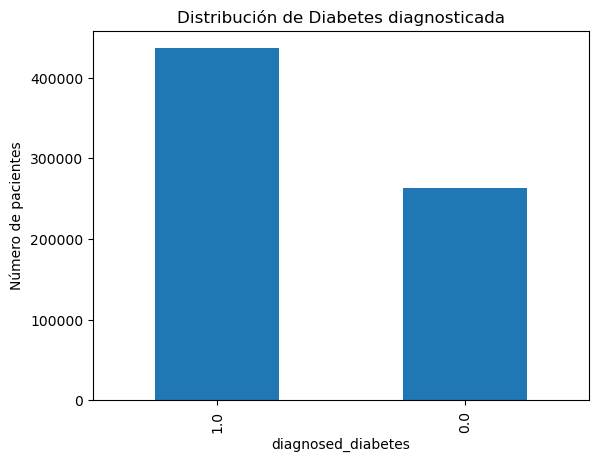

In [70]:
train_df['diagnosed_diabetes'].value_counts().plot(kind='bar', title='Distribución de Diabetes diagnosticada')
plt.ylabel('Número de pacientes')
plt.show()

###

In [ ]:
# Proorción de clases
train_df['diagnosed_diabetes'].value_counts()/len(train_df)

diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: count, dtype: float64

#### Calculo valores nulos. Observo que no hay.

In [112]:
train_df.isna().sum()

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


#### Hago un describe para observar la distribución de los datos.

In [113]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,700000.0,349999.500000,202072.738554,0.00,174999.75,349999.50,524999.25,699999.00
age,700000.0,50.359734,11.655520,19.00,42.00,50.00,58.00,89.00
alcohol_consumption_per_week,700000.0,2.072411,1.048189,1.00,1.00,2.00,3.00,9.00
physical_activity_minutes_per_week,700000.0,80.230803,51.195071,1.00,49.00,71.00,96.00,747.00
diet_score,700000.0,5.963695,1.463336,0.10,5.00,6.00,7.00,9.90
sleep_hours_per_day,700000.0,7.002200,0.901907,3.10,6.40,7.00,7.60,9.90
screen_time_hours_per_day,700000.0,6.012733,2.022707,0.60,4.60,6.00,7.40,16.50
bmi,700000.0,25.874684,2.860705,15.10,23.90,25.90,27.80,38.40
waist_to_hip_ratio,700000.0,0.858766,0.037980,0.68,0.83,0.86,0.88,1.05
systolic_bp,700000.0,116.294193,11.010390,91.00,108.00,116.00,124.00,163.00


#### Creo variables para los datos de entrada y salida

In [ ]:
# Descarto columnas irrelevantes
X = train_df.drop(columns=["diagnosed_diabetes", "id"])
# Target variable
y = train_df["diagnosed_diabetes"]

#### Separo variables categóricas y numéricas.

In [129]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols   = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
Numerical: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


#### Genero los histogramas de las variables numéricas para ver su distribución.

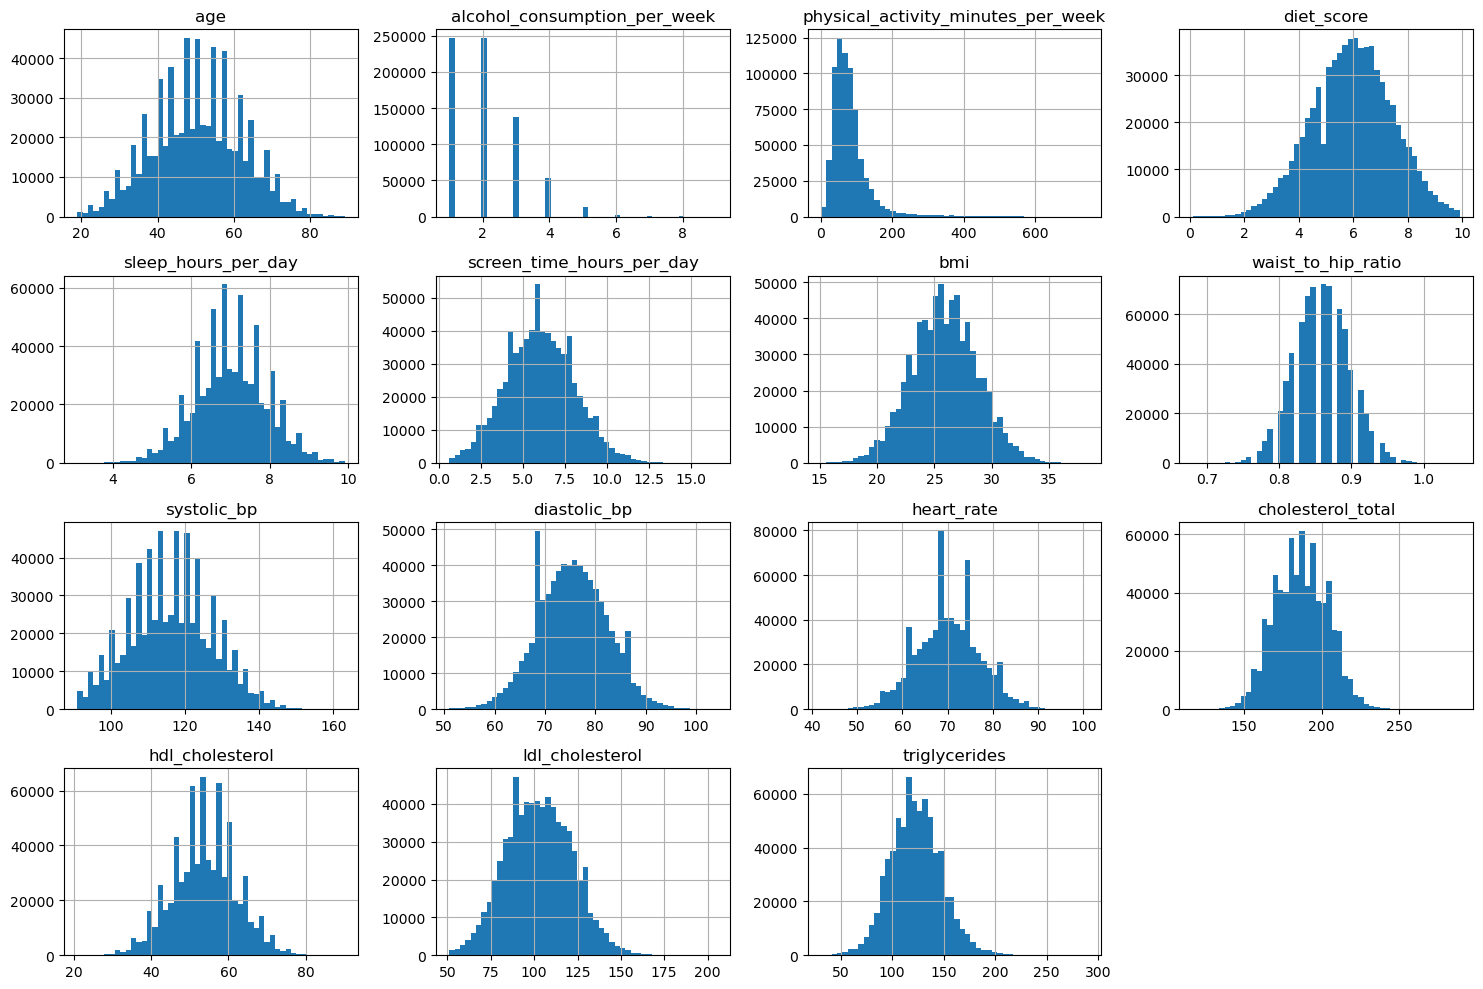

In [206]:
X[numerical_cols].hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

#### Genero diagramas de bigotes. Se pueden observar los outliers.

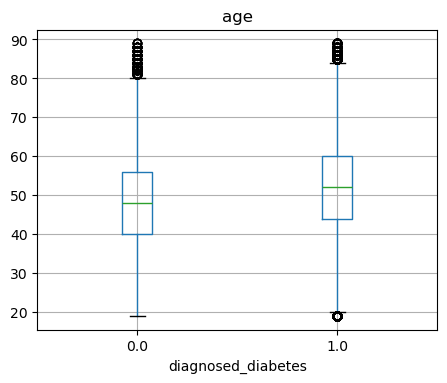

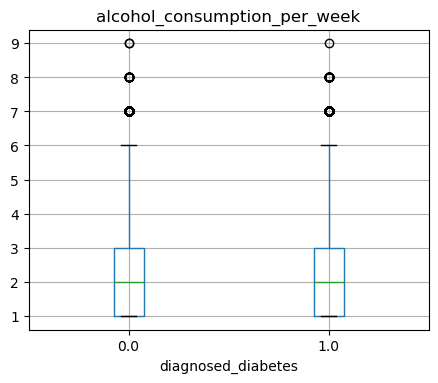

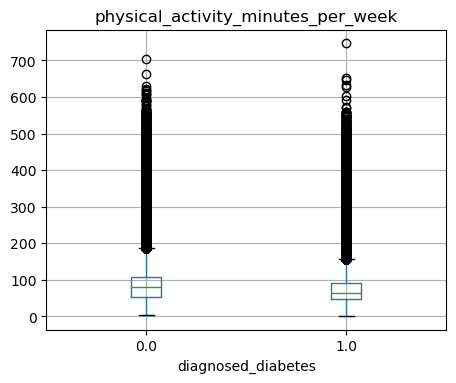

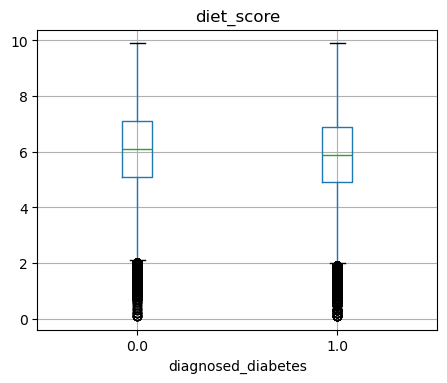

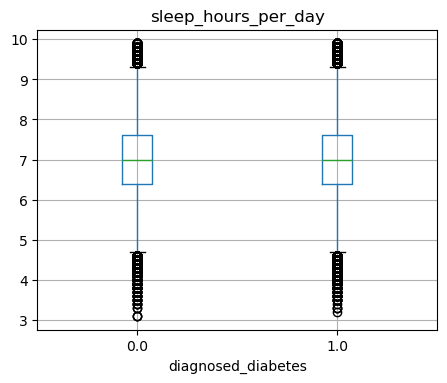

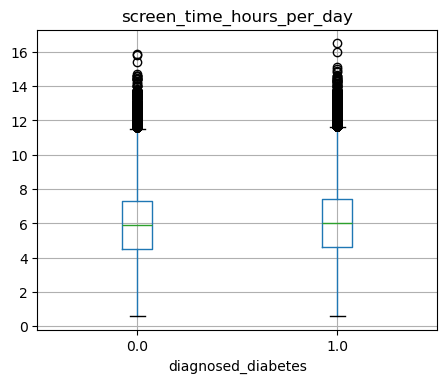

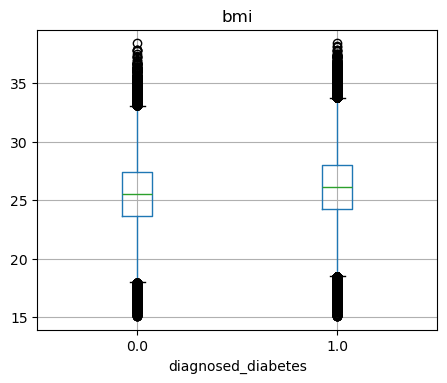

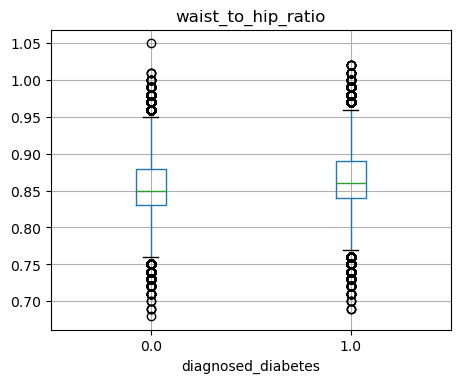

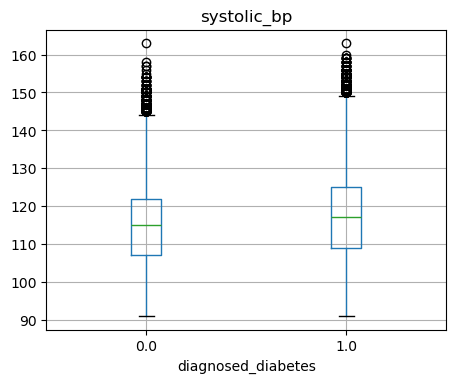

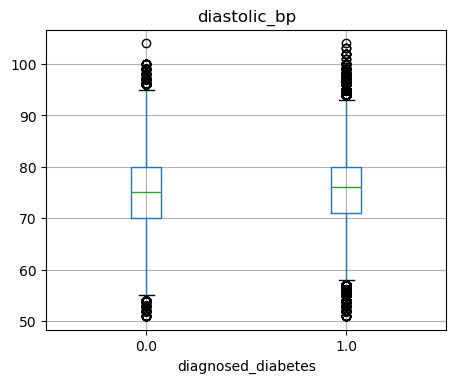

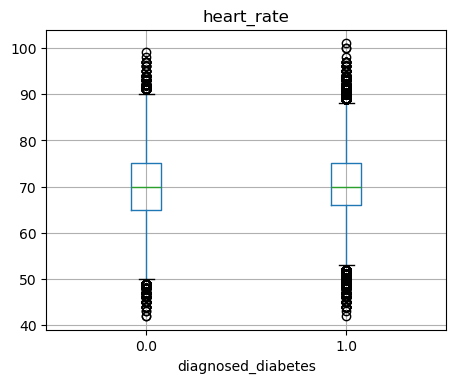

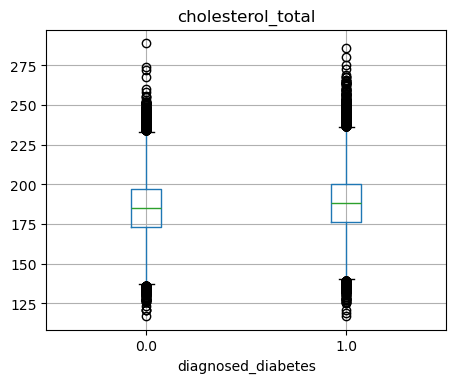

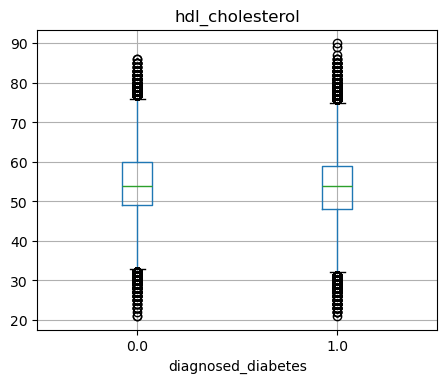

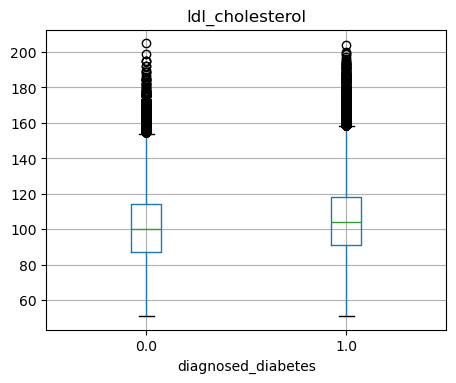

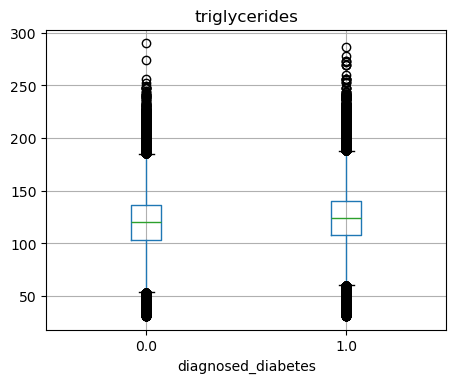

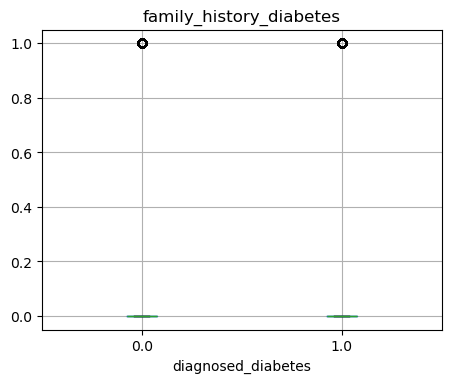

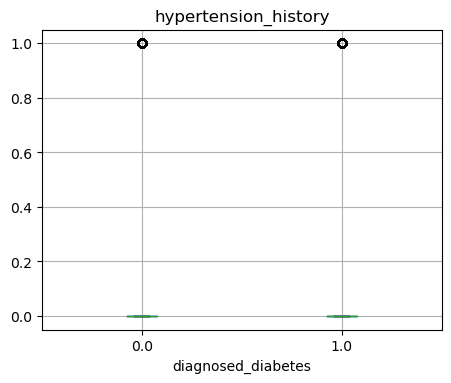

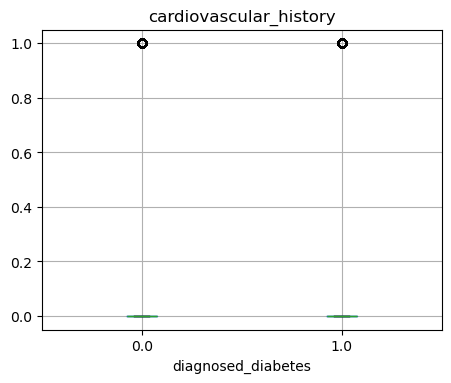

In [131]:
for col in numerical_cols:  
    train_df.boxplot(column=col, by="diagnosed_diabetes", figsize=(5, 4))
    plt.title(col)
    plt.suptitle('')
    plt.show()

#### Se observa que algunas columnas solo tienen valores 0 1, con lo cual se pueden separar como variables binarias en lugar de numéricas.

#### Calulo los porcentajes de las categorías de cada variable categórica para ver su distribución.

In [207]:
for col in categorical_cols:
    print(f"Column: {col}")
    print(X[col].value_counts(normalize=True))


Column: gender
gender
Female    0.518910
Male      0.475836
Other     0.005254
Name: proportion, dtype: float64
Column: ethnicity
ethnicity
White       0.551647
Hispanic    0.185691
Black       0.151859
Asian       0.085886
Other       0.024917
Name: proportion, dtype: float64
Column: education_level
education_level
Highschool      0.491636
Graduate        0.373240
Postgraduate    0.113774
No formal       0.021350
Name: proportion, dtype: float64
Column: income_level
income_level
Middle          0.415081
Lower-Middle    0.255100
Upper-Middle    0.182623
Low             0.122576
High            0.024620
Name: proportion, dtype: float64
Column: smoking_status
smoking_status
Never      0.706354
Current    0.147661
Former     0.145984
Name: proportion, dtype: float64
Column: employment_status
employment_status
Employed      0.737386
Retired       0.165336
Unemployed    0.071124
Student       0.026154
Name: proportion, dtype: float64


#### Genero gráficos de las cuentas de diagnosticos de diabetes para cada categoría.

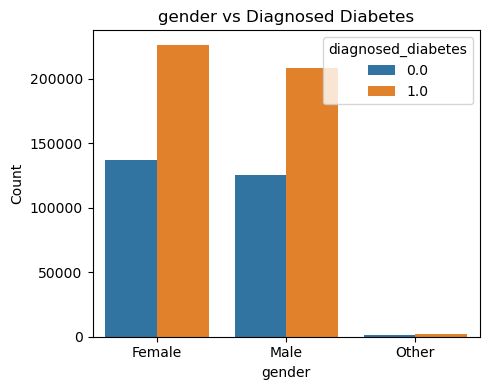

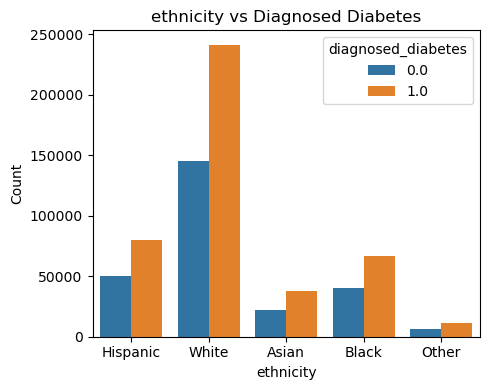

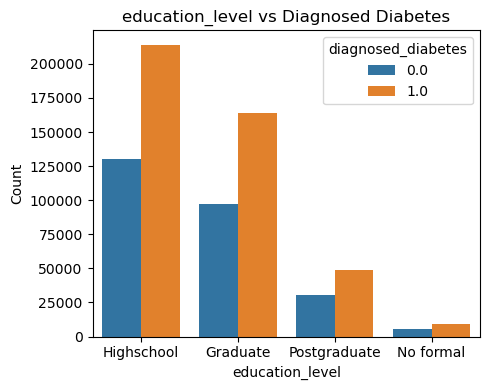

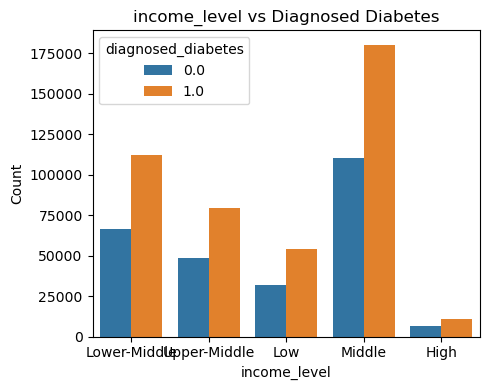

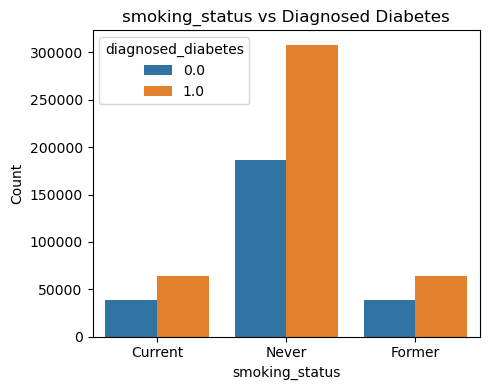

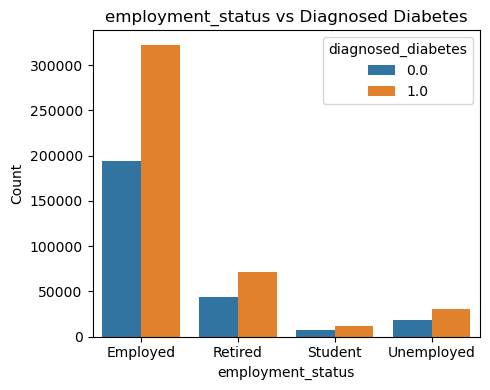

In [166]:
for col in categorical_cols:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=train_df, x=col, hue='diagnosed_diabetes')
    plt.title(f"{col} vs Diagnosed Diabetes")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

#### Separo variables binarias y genero gráficas para ver su distribución según los casos positivos y negativos de diabetes.

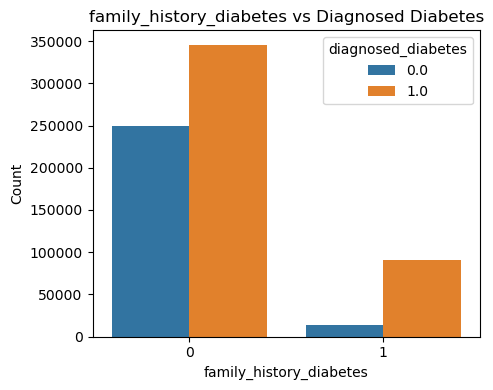

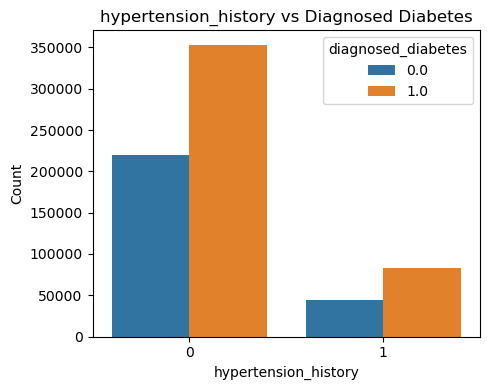

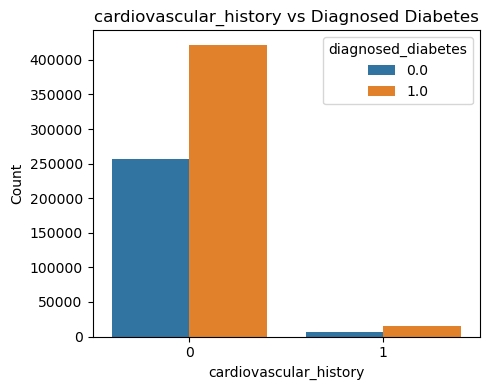

In [167]:
variables_binarias = ['family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
for col in variables_binarias:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=train_df, x=col, hue='diagnosed_diabetes')
    plt.title(f"{col} vs Diagnosed Diabetes")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()    

#### Genero la matriz de correlaciones.

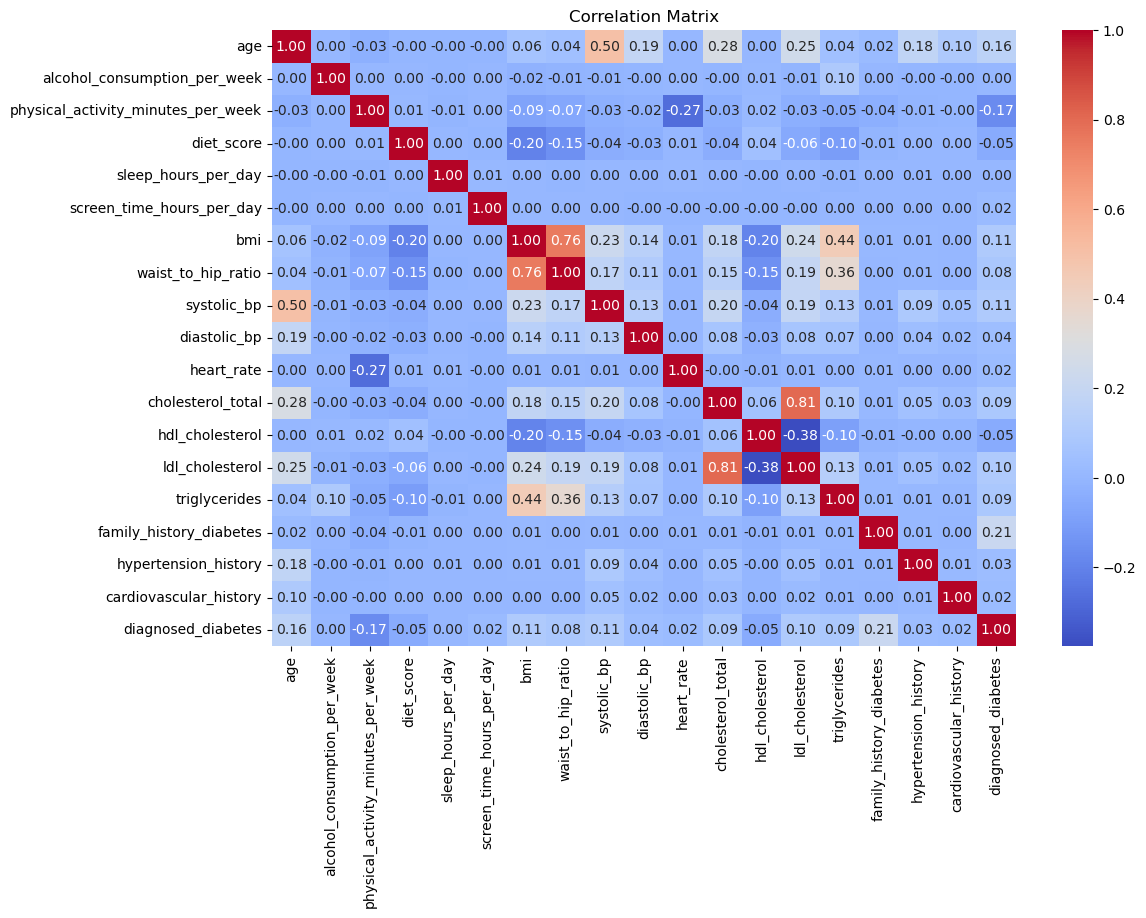

In [135]:
corr = train_df[numerical_cols + ['diagnosed_diabetes']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Calculo los cuantiles q1 y q99 para ver cuantos valores son outliers.

In [136]:
for col in numerical_cols:
    q1 = train_df[col].quantile(0.01)
    q99 = train_df[col].quantile(0.99)
    print(f"{col}: [{q1:.2f}, {q99:.2f}]")


age: [25.00, 76.00]
alcohol_consumption_per_week: [1.00, 5.00]
physical_activity_minutes_per_week: [16.00, 304.00]
diet_score: [2.50, 9.30]
sleep_hours_per_day: [4.90, 9.10]
screen_time_hours_per_day: [1.50, 10.90]
bmi: [19.30, 32.60]
waist_to_hip_ratio: [0.77, 0.95]
systolic_bp: [93.00, 141.00]
diastolic_bp: [60.00, 91.00]
heart_rate: [54.00, 86.00]
cholesterol_total: [150.00, 225.00]
hdl_cholesterol: [35.00, 73.00]
ldl_cholesterol: [61.00, 148.00]
triglycerides: [67.00, 187.00]
family_history_diabetes: [0.00, 1.00]
hypertension_history: [0.00, 1.00]
cardiovascular_history: [0.00, 1.00]


#### En vista de todos los datos decido utilizar todas las variables de entrada.

#### Separa variables binarias de las numéricas.

In [148]:
binary_cols = [
    "family_history_diabetes",
    "hypertension_history",
    "cardiovascular_history"
]

numerical_cols = [
    col for col in X.columns
    if col not in categorical_cols + binary_cols
]

#### Búsqueda del mejor modelo. Preprocesamiento

In [ ]:
# Preproceso los datos codificando categóricas, escalando numéricas y dejando binarias tal cual. Para el modelo LightGBM no es necesario escalar, pero lo incluyo para posibles futuros modelos.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numerical_cols),
        ("bin", "passthrough", binary_cols)
    ]
)


#### Selecciono modelo y ajusto parámetros.

In [171]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42,
    n_jobs=-1
)


#### Creo un pipeline con el preprocesamiento de los datos y el modelo.

In [172]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", lgb_model)
    ]
)


#### Separo datos de entrenamiento y validación.

In [173]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)



#### Entreno el modelo.

In [174]:
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### Calculo la predicción del modelo utilizando los datos de validación. Calculo las métricas y genero la curva ROC.

Validation ROC-AUC: 0.72516


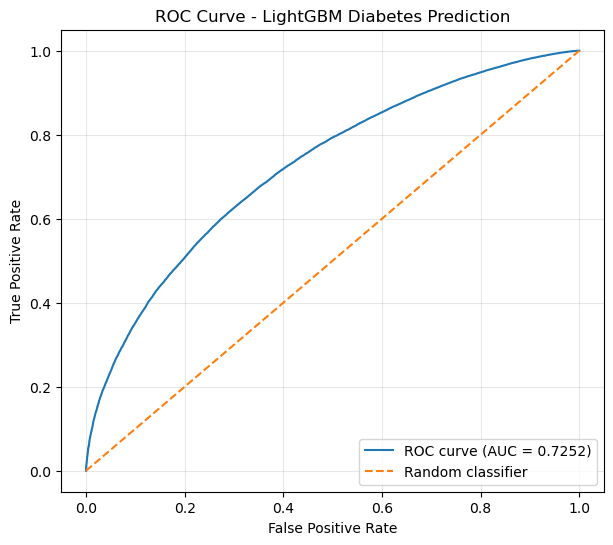

In [175]:
y_val_pred = pipeline.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)

print(f"Validation ROC-AUC: {roc_auc:.5f}")

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM Diabetes Prediction")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


#### Elijo un threshold de 0.5 inicial y genero la matrix de confusión.

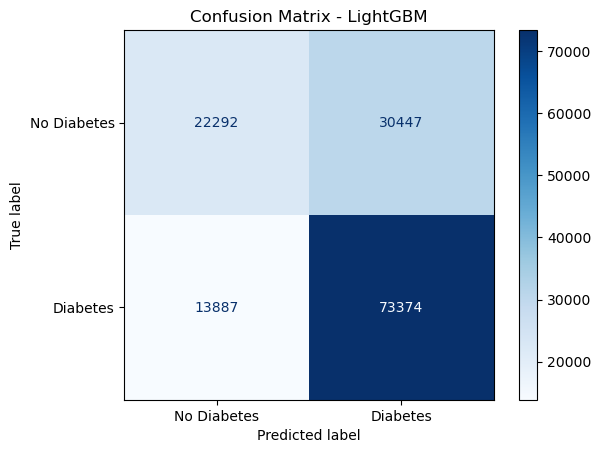

In [177]:
# Threshold (ajustable)
threshold = 0.5

# Probabilidades → clases
y_val_pred_prob = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_prob >= threshold).astype(int)

# Calcular matriz
cm = confusion_matrix(y_val, y_val_pred)

# Plot con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LightGBM")
plt.show()


#### Busco el threshold para el mejor F1-score.

In [ ]:
y_val_pred_prob = pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)
f1_scores = []

for t in thresholds:
    y_pred = (y_val_pred_prob >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))

best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best threshold (F1): {best_threshold_f1:.2f}")
print(f"Best F1-score     : {best_f1:.4f}")

Best threshold (F1): 0.41
Best F1-score     : 0.7803


#### Calculo las métricas.

In [ ]:
threshold = best_threshold_f1

y_val_pred = (y_val_pred_prob >= threshold).astype(int)

print(f"Threshold usado: {threshold:.2f}")
print(f"Accuracy : {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall   : {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-score : {f1_score(y_val, y_val_pred):.4f}")

Threshold usado: 0.41
Accuracy : 0.6714
Precision: 0.6690
Recall   : 0.9359
F1-score : 0.7803


#### Genero la matriz de confusión para el threshold seleccionado.

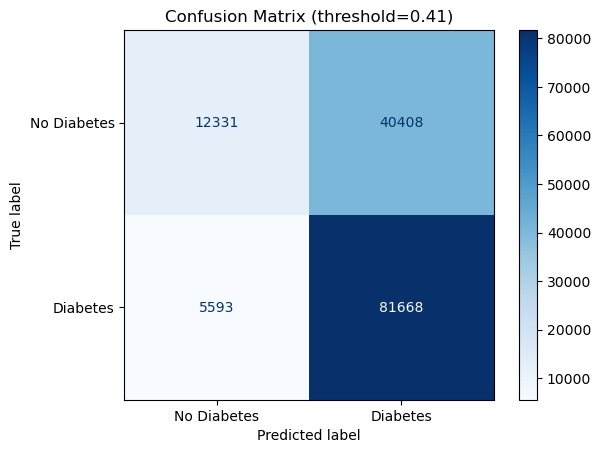

In [180]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (threshold={threshold:.2f})")
plt.show()


In [181]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 300),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "objective": "binary",
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1
    }

    model = lgb.LGBMClassifier(**params)

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ]
    )

    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_pred)

    return roc_auc


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best ROC-AUC:", study.best_value)
print("Best parameters:")
study.best_params


[I 2025-12-29 16:03:02,106] A new study created in memory with name: no-name-8e7c8d59-6499-4c99-8b2f-23d748b13d11
[I 2025-12-29 16:03:10,124] Trial 0 finished with value: 0.7167092967367698 and parameters: {'n_estimators': 354, 'learning_rate': 0.013053427768260292, 'num_leaves': 160, 'max_depth': 8, 'min_child_samples': 142, 'subsample': 0.8153748130464263, 'colsample_bytree': 0.9752219364232136, 'reg_alpha': 3.115633677380862, 'reg_lambda': 4.607152735588354}. Best is trial 0 with value: 0.7167092967367698.
[I 2025-12-29 16:03:34,947] Trial 1 finished with value: 0.7259358158541752 and parameters: {'n_estimators': 1090, 'learning_rate': 0.036414594246139784, 'num_leaves': 178, 'max_depth': 11, 'min_child_samples': 76, 'subsample': 0.9684629769591212, 'colsample_bytree': 0.9329084736755657, 'reg_alpha': 3.747318116097797, 'reg_lambda': 2.2136850047414547}. Best is trial 1 with value: 0.7259358158541752.
[I 2025-12-29 16:03:42,039] Trial 2 finished with value: 0.7270376272901282 and pa

Best ROC-AUC: 0.7279824096275779
Best parameters:


{'n_estimators': 1095,
 'learning_rate': 0.05128049727665316,
 'num_leaves': 105,
 'max_depth': 6,
 'min_child_samples': 240,
 'subsample': 0.6523220944035687,
 'colsample_bytree': 0.7059371903778998,
 'reg_alpha': 1.7706400368169564,
 'reg_lambda': 3.163859534226907}

In [183]:
best_params = study.best_params

best_model = lgb.LGBMClassifier(
    **best_params,
    objective="binary",
    random_state=42,
    n_jobs=-1
)

final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", best_model)
    ]
)

final_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [184]:
y_val_pred_prob = final_pipeline.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Final ROC-AUC (tuned): {roc_auc:.5f}")


Final ROC-AUC (tuned): 0.72798


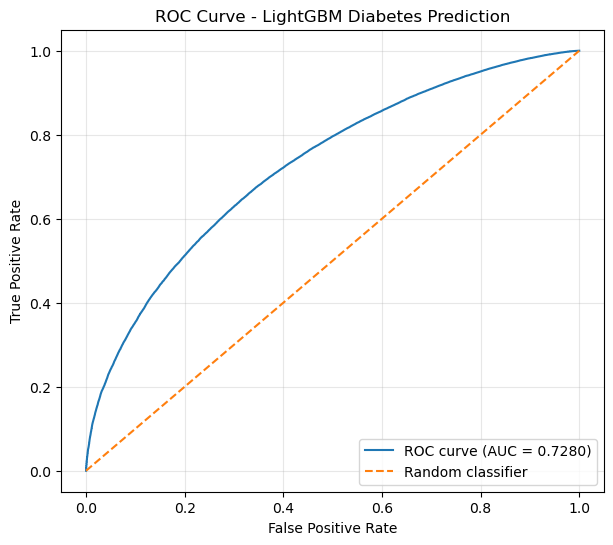

In [185]:
# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM Diabetes Prediction")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [186]:
y_val_pred_prob = final_pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)
f1_scores = []

for t in thresholds:
    y_pred = (y_val_pred_prob >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))

best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best threshold (F1): {best_threshold_f1:.2f}")
print(f"Best F1-score     : {best_f1:.4f}")

Best threshold (F1): 0.40
Best F1-score     : 0.7814


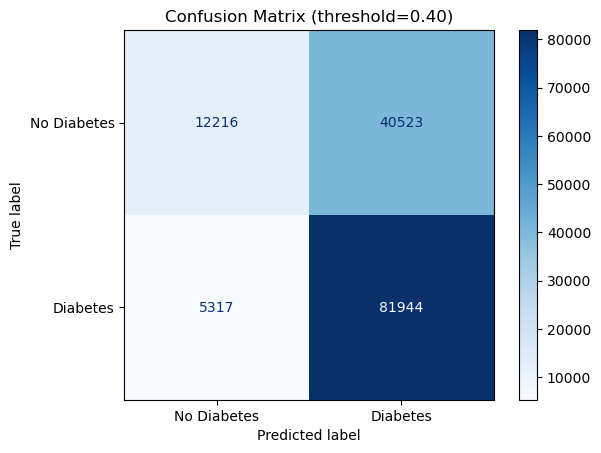

In [187]:
cm = confusion_matrix(y_val, y_val_pred_prob >= best_threshold_f1)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Diabetes", "Diabetes"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (threshold={best_threshold_f1:.2f})")
plt.show()

In [189]:
param_dist = {
    "model__n_estimators": [300, 500, 800, 1000],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__num_leaves": [31, 63, 127],
    "model__max_depth": [-1, 6, 8, 10],
    "model__min_child_samples": [20, 50, 100, 200],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.7, 0.8, 0.9],
}


In [196]:
lgb_model = lgb.LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", lgb_model)
    ]
)


In [197]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 232698, number of negative: 140636
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1667
[LightGBM] [Info] Number of data points in the train set: 373334, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623297 -> initscore=0.503566
[LightGBM] [Info] Start training from score 0.503566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [In

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__colsample_bytree': [0.7, 0.8, ...], 'model__learning_rate': [0.01, 0.03, ...], 'model__max_depth': [-1, 6, ...], 'model__min_child_samples': [20, 50, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [199]:
print("Best ROC-AUC:", search.best_score_)
print("Best params:")
search.best_params_


Best ROC-AUC: 0.7261540906825695
Best params:


{'model__subsample': 0.9,
 'model__num_leaves': 31,
 'model__n_estimators': 1000,
 'model__min_child_samples': 100,
 'model__max_depth': 10,
 'model__learning_rate': 0.05,
 'model__colsample_bytree': 0.7}

In [200]:
best_params = search.best_params_

best_model = lgb.LGBMClassifier(
    **best_params,
    objective="binary",
    random_state=42,
    n_jobs=-1
)

final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", best_model)
    ]
)

final_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [201]:
y_val_pred_prob = final_pipeline.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.0, 1.0, 101)
f1_scores = []

for t in thresholds:
    y_pred = (y_val_pred_prob >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))

best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Best threshold (F1): {best_threshold_f1:.2f}")
print(f"Best F1-score     : {best_f1:.4f}")


Best threshold (F1): 0.41
Best F1-score     : 0.7792


In [202]:
y_val_pred_prob = final_pipeline.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Final ROC-AUC (tuned): {roc_auc:.5f}")

Final ROC-AUC (tuned): 0.72182


In [203]:
param_grid = {
    "model__n_estimators": [300, 600],
    "model__learning_rate": [0.03, 0.05],
    "model__num_leaves": [31, 63],
    "model__min_child_samples": [30, 100],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.8]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)


In [204]:
grid_search.fit(X_train, y_train)

print("Best ROC-AUC:", grid_search.best_score_)
print("Best parameters:")
grid_search.best_params_


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1669
[LightGBM] [Info] Number of data points in the train set: 373333, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623296 -> initscore=0.503562
[LightGBM] [Info] Start training from score 0.503562
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Number of positive: 232697, number of negative: 140636
[LightGBM] [Info] Number of positive: 232698, number of negative: 140636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036744 seconds.
You can set `force_row_wise=true` to remove the overhead.

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.05,
 'model__min_child_samples': 100,
 'model__n_estimators': 600,
 'model__num_leaves': 63,
 'model__subsample': 0.8}

In [205]:
best_model = grid_search.best_estimator_

y_val_pred = best_model.predict_proba(X_val)[:, 1]

print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_pred))


Validation ROC-AUC: 0.7266485459167342
